### 初始化

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_expert: bool


graph_builder = StateGraph(State)

### 添加 chatbot 节点

In [2]:
import os
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.
    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    request: str

search_tool = TavilySearchResults(max_results=2)
tools_schema = [search_tool, RequestAssistance]

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["L_OPENAI_API_BASE"],
    azure_deployment='gpt-4o-deployment',
    openai_api_version='2024-02-15-preview',
    openai_api_key=os.environ["L_OPENAI_API_KEY"],
)
llm_with_tools = llm.bind_tools(tools_schema)


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_expert = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_expert = True
    return {"messages": [response], "ask_expert": ask_expert}
    
graph_builder.add_node("chatbot", chatbot)

### 添加工具集节点

In [3]:
from langgraph.prebuilt import ToolNode

graph_builder.add_node("search_tools", ToolNode(tools=[search_tool]))

### 添加用户手动节点

In [4]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def expert_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("No response from an expert.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_expert": False,
    }

graph_builder.add_node("expert", expert_node)

### 绘制路径

In [5]:
from langgraph.prebuilt import tools_condition

def select_next_node(state: State):
    if state["ask_expert"]:
        return "expert"
    return tools_condition(state)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"expert": "expert", "tools": "search_tools", "__end__": "__end__"},
)
graph_builder.add_edge("search_tools", "chatbot")
graph_builder.add_edge("expert", "chatbot")

### 编译 Graph

In [6]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["expert"])

### 运行

In [7]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_mVvItfciYK4bZP8eQev4QaLd)
 Call ID: call_mVvItfciYK4bZP8eQev4QaLd
  Args:
    request: I need expert guidance for building an AI agent.


In [8]:
snapshot = graph.get_state(config)
print(snapshot.next)

existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

('expert',)
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_mVvItfciYK4bZP8eQev4QaLd)
 Call ID: call_mVvItfciYK4bZP8eQev4QaLd
  Args:
    request: I need expert guidance for building an AI agent.


### 介入状态

In [9]:
from langchain_core.messages import AIMessage, ToolMessage

ai_message = snapshot.values["messages"][-1]
expert_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(expert_response, ai_message)
graph.update_state(
    config,
    {"messages": [tool_message]}
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef70e55-b8f7-672e-8002-e3b8ada34710'}}

In [10]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='fb8182a0-b759-4125-b4c5-b14627b8204a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mVvItfciYK4bZP8eQev4QaLd', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent."}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 160, 'total_tokens': 184}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id

In [11]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent, as it is more reliable and extensible than simpler autonomous agents. If you need further assistance or specific guidance on any aspects of building your AI agent, feel free to ask!


### 打印 Graph

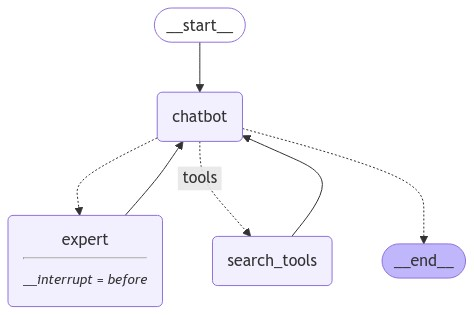

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 读取 state

In [13]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='fb8182a0-b759-4125-b4c5-b14627b8204a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mVvItfciYK4bZP8eQev4QaLd', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent."}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 160, 'total_tokens': 184}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_80a1bad4c7', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 